# **Курс Специализация Data Science Дипломный проект. Бриф учебного кейса**

# «Модель прогнозирования стоимости жилья для агентства недвижимости»



In [6]:
#импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import category_encoders as ce

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats


from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


# **Разведывательный анализ (EDA)**

In [7]:
temp_data=pd.read_csv('temp_data_2.csv')

### **Анализ категориальных признаков**

#### 'state'

In [8]:
fig_bar = px.bar(
    data_frame = temp_data.groupby('state',as_index=False)['target'].median(),
    x='state',
    y ='target',
    color='state',
    height=400,
    width=700,
    title='Distibiution of median price by state'
)
#fig_bar.show()

<image src=".\images\state.png">

Медианная стоимость объектов недвижимости выше в штате Калифорния, Коламбия, Нью-Йорк, Массачусетс.

#### 'property_type'

In [30]:
fig_bar = px.bar(
    data_frame = temp_data.groupby('property_type',as_index=False)['target'].count(),
    x='property_type',
    y ='target',
    color='property_type',
    height=600,
    width=1000,
    title='Distibiution of median price by property_type'
)
#fig_bar.show()

<image src=".\images\bar_type.png">

Наибольшее количество предложений на рынке представлен в группе single family, т.е. дома для одной семьи.

In [31]:
fig_bar = px.box(
    data_frame = temp_data,
    x='target',
    y ='property_type',
    color='property_type',
    height=600,
    width=1200,
    title='Distibiution of target by property_type'
)
#fig_bar.show()

<image src=".\images\box_type_target.png">

Самая высокая мединная стоимость в группе multi family, самая низкая  -  в группе мобильных домов.

#### 'year_built_group'

In [32]:
fig_bar = px.bar(
    data_frame = temp_data.groupby('year_built_group',as_index=False)['target'].median(),
    x='year_built_group',
    y ='target',
    color='year_built_group',
    height=400,
    width=700,
    title='Distibiution of median price by year_built_group '
)
#fig_bar.show()

<image src=".\images\year_built_g.png">

На графике не видно зависимости от групп, есть завышенная стоимость в группе 1700-1750, но это можно считать как выброс, потому что в этой группе мало данных. Поэтому эту группу не будем использовать в дальнешей работе.

#### Булевные признаки

In [12]:
types = temp_data.dtypes
bool_features = list(types[types == 'bool'].index)
print(f'Булевные признаки:',bool_features)


Булевные признаки: ['fireplace', 'private_pool', 'heating', 'cooling', 'parking', 'remodeled', 'schools_high_rating', 'school_info']


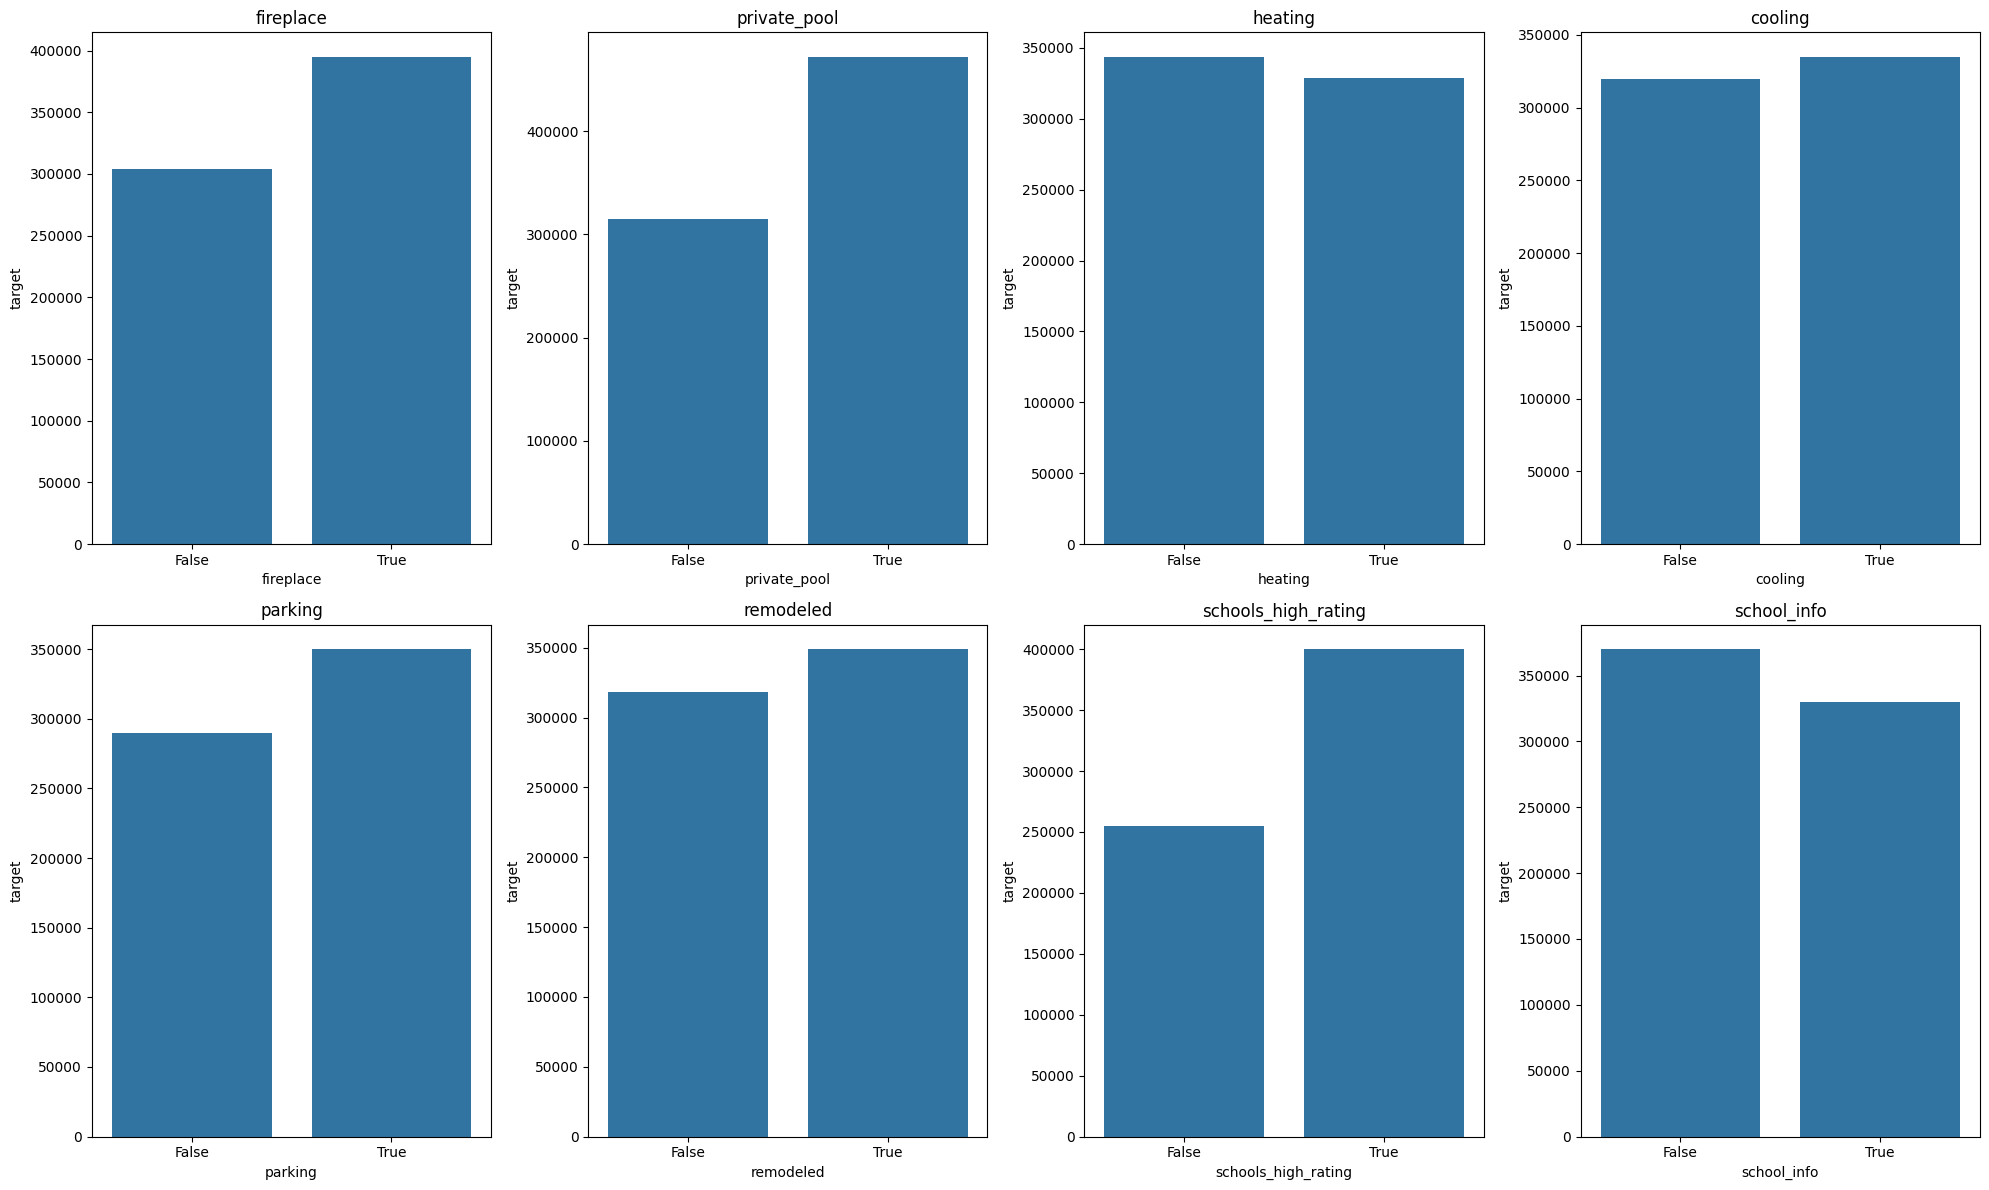

In [13]:
# построим графики для булевных значений
n = len(bool_features)
rows = 2
cols = (n + 1) // rows  

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

axes = axes.flatten()  


for i, feature in enumerate(bool_features): 
    temp_data_grouped = temp_data.groupby(feature,as_index=False)['target'].median()
    barplot = sns.barplot(data=temp_data_grouped, x=feature, y='target', ax=axes[i])

    barplot.set_title('{}'.format(feature))

plt.tight_layout()


Проведем статистический тест на T-критерий. Несмотря на то, что данные распределены ненормально, мы имеем достаточно большую выборку, а непараметрические тесты плохо работают на больших данных.




In [14]:
data_no_school=temp_data[temp_data['school_info']==False]['target']
data_school=temp_data[temp_data['school_info']==True]['target']

In [15]:
from scipy.stats import ttest_ind


# выдвинем две гипотезы:
H0 = 'Стоимость жилья не зависит от информации о школе'
Ha = 'Стоимость объектов недвижимости различается (мы отвергаем H0)'

# уровень значимости
alpha = 0.05

_, p = ttest_ind(data_no_school,data_school)

print('p=%.3f' % p)

# Интерпретация

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Стоимость объектов недвижимости различается (мы отвергаем H0)


In [16]:
temp_data.to_csv('temp_data.csv',index=False)

## **Отбор и проектирование новых признаков**

In [17]:
train_data=temp_data.copy()
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (281037, 22)


In [18]:
# обработаем данные
def preprocess__data(data):
    
    cols_to_as_category = ['zipcode','city','year built','state','status_new','property_type','mean_distance_school']
    drop_columns = ['street', 'lotsize','year_built_group']

    # прологарифмируем числовые данные, т.к. они имеют большой разброс и выбросы
    data['sqft']=np.log(data['sqft']+1)
    data['target_log']=np.log(data['target']+1)

    # переведем в категориальные признаки
    data['year built'] = data['year built'].replace(-1, 'unknown').astype('str')
    data['mean_distance_school'] = data['mean_distance_school'].replace(-1, 'unknown').astype('str')

    for col in cols_to_as_category:
        data[col] = data[col].astype('category')

    data = data.drop(drop_columns, axis=1)

    return data

train_data=preprocess__data(train_data)

print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (281037, 20)


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281037 entries, 0 to 281036
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   baths                 281037 non-null  float64 
 1   fireplace             281037 non-null  bool    
 2   sqft                  281037 non-null  float64 
 3   zipcode               281037 non-null  category
 4   state                 281037 non-null  category
 5   target                281037 non-null  int64   
 6   private_pool          281037 non-null  bool    
 7   status_new            281037 non-null  category
 8   property_type         281037 non-null  category
 9   beds                  281037 non-null  float64 
 10  city                  281037 non-null  category
 11  year built            281037 non-null  category
 12  heating               281037 non-null  bool    
 13  cooling               281037 non-null  bool    
 14  parking               281037 non-nul

In [20]:
train_data.describe()

,baths,sqft,target,beds,target_log
count,281037.000000,281037.000000,2.810370e+05,281037.000000,281037.000000
mean,2.638266,7.614077,5.438733e+05,3.180894,12.744467
std,1.334510,0.609003,7.392073e+05,1.411836,0.932394
min,0.000000,4.948760,1.330000e+04,0.000000,9.495594
25%,2.000000,7.210818,2.079000e+05,2.000000,12.244817
50%,2.000000,7.552237,3.300000e+05,3.000000,12.706851
75%,3.000000,7.917536,5.750000e+05,4.000000,13.262127
max,33.000000,10.507569,8.200000e+06,40.000000,15.919645


In [21]:
train_data.describe(include='category')

,zipcode,state,status_new,property_type,city,year built,mean_distance_school
count,281037,281037,281037,281037,281037,281037,281037
unique,4092,34,14,10,1189,218,41
top,32137,FL,sale,single family,Houston,2019,1.0
freq,1565,79672,182842,182695,17392,27057,107087


In [22]:
# используем класса LabelEncoder() для признаков с уникальным количеством наименований больше 40
lab_enc = preprocessing.LabelEncoder()
train_data['zipcode'] = lab_enc.fit_transform(train_data['zipcode'])


lab_enc = preprocessing.LabelEncoder()
train_data['year built'] = lab_enc.fit_transform(train_data['year built'])

lab_enc = preprocessing.LabelEncoder()
train_data['city'] = lab_enc.fit_transform(train_data['city'])

lab_enc = preprocessing.LabelEncoder()
train_data['mean_distance_school'] = lab_enc.fit_transform(train_data['mean_distance_school'])

In [23]:
# для остальных используем способ "горячего" кодирования
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')
data_onehot = one_hot_encoder.fit_transform(train_data[['state', 'status_new', 'property_type']]).toarray()

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot.head()

,state_CA,state_CO,state_DC,state_DE,state_FL,state_GA,state_IA,state_IL,state_IN,state_KY,...,status_new_under,property_type_condo/townhome/row home/co-op,property_type_coop,property_type_farm,property_type_lot/land,property_type_mobile,property_type_multi family,property_type_other,property_type_single family,property_type_townhouse
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
columns_to_change = ['state', 'status_new', 'property_type']
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (281037, 72)


In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281037 entries, 0 to 281036
Data columns (total 72 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   baths                                        281037 non-null  float64
 1   fireplace                                    281037 non-null  bool   
 2   sqft                                         281037 non-null  float64
 3   zipcode                                      281037 non-null  int64  
 4   target                                       281037 non-null  int64  
 5   private_pool                                 281037 non-null  bool   
 6   beds                                         281037 non-null  float64
 7   city                                         281037 non-null  int32  
 8   year built                                   281037 non-null  int32  
 9   heating                                      281037 non-nul

<Axes: >

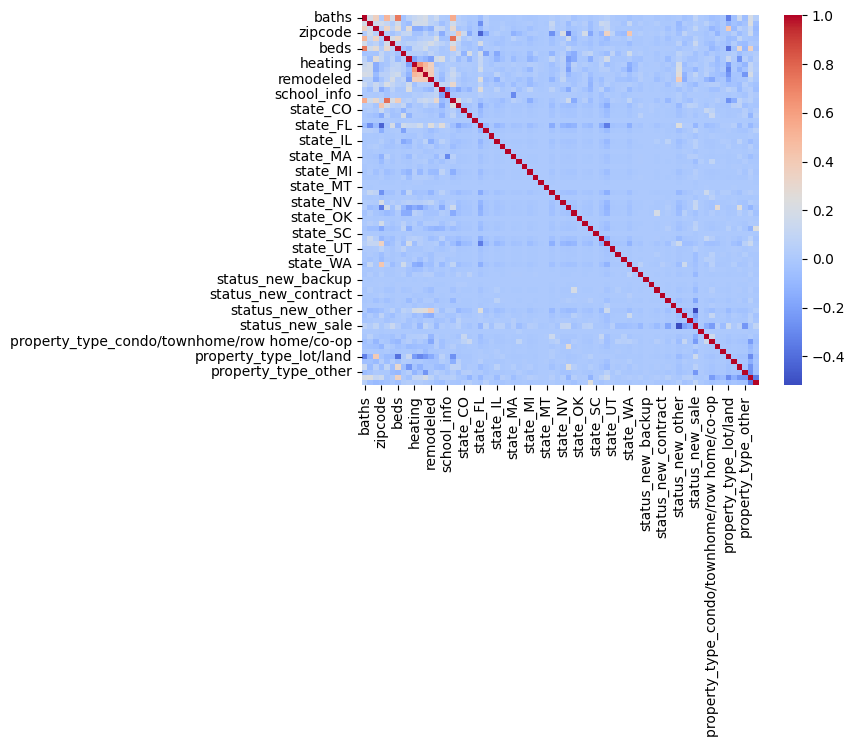

In [26]:
#построим матрицу корреляций
corr_full=train_data.corr()
sns.heatmap(corr_full, annot=False, cmap='coolwarm')


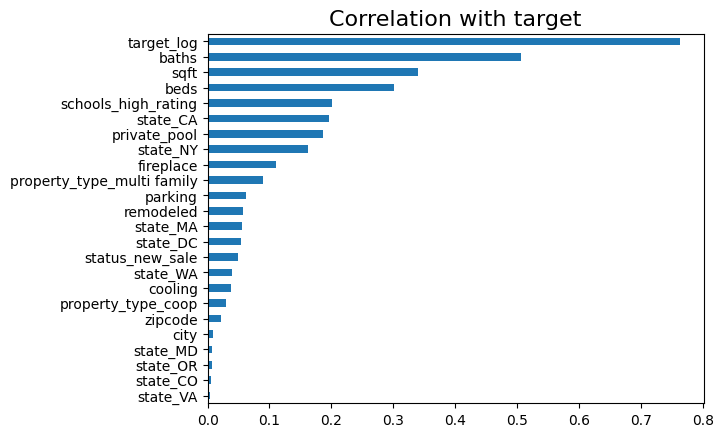

In [27]:
corr_full['target'].sort_values()[-25:-1].plot.barh()
plt.title("Correlation with target", fontsize = 16)
plt.show()

In [28]:
# проверка на мультиколлинеарность
corr_feat=corr_full['target'].sort_values(ascending=False)
corr_feat[corr_feat>0.9]

target    1.0
Name: target, dtype: float64

Мультиколлинеарность в данных отсутствует

In [29]:
train_data.to_csv('train_data.csv',index=False)